#  Прогнозирование заказов такси

**Описание целей и задачи проекта**

Закачик Компания «Чётенькое такси». Постройте модель, чтобы привлекать больше водителей в период пиковой нагрузки, спрогнозировать количество заказов такси на следующий час.
Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Описание данных**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. 
Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**План работы**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [18]:
# импорт библиотек
import os
import time
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller


# модели
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit

In [19]:
# пути к файлам
pth1 = '/datasets/taxi.csv'
pth2 = '/Users/refresh/Downloads/taxi.csv'

# открытие файлов
if os.path.exists(pth1):
    data = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    data = pd.read_csv(pth2,  index_col=[0], parse_dates=[0])
else:
    print('Что-то пошло не так')

In [20]:
# знакомимся с информацией
display(data.head(5))
display(data.describe())
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [21]:
data.sort_index(inplace=True)
if data.index.is_monotonic == True:
    print('Индекс монотонно увеличивается')
else:
    print('Индекс не монотонный')

Индекс монотонно увеличивается


**Вывод**

В таблице нет пропусков, тип данных соответсвует. Индекс даты монотонно возрастает с 2018-03-01 00:00:00 до 2018-08-31 23:50:00, интервал 10 минут. 

## Анализ

Декомбозируем по одному часу и посмотрим тренд, сезонность и шум в данных.

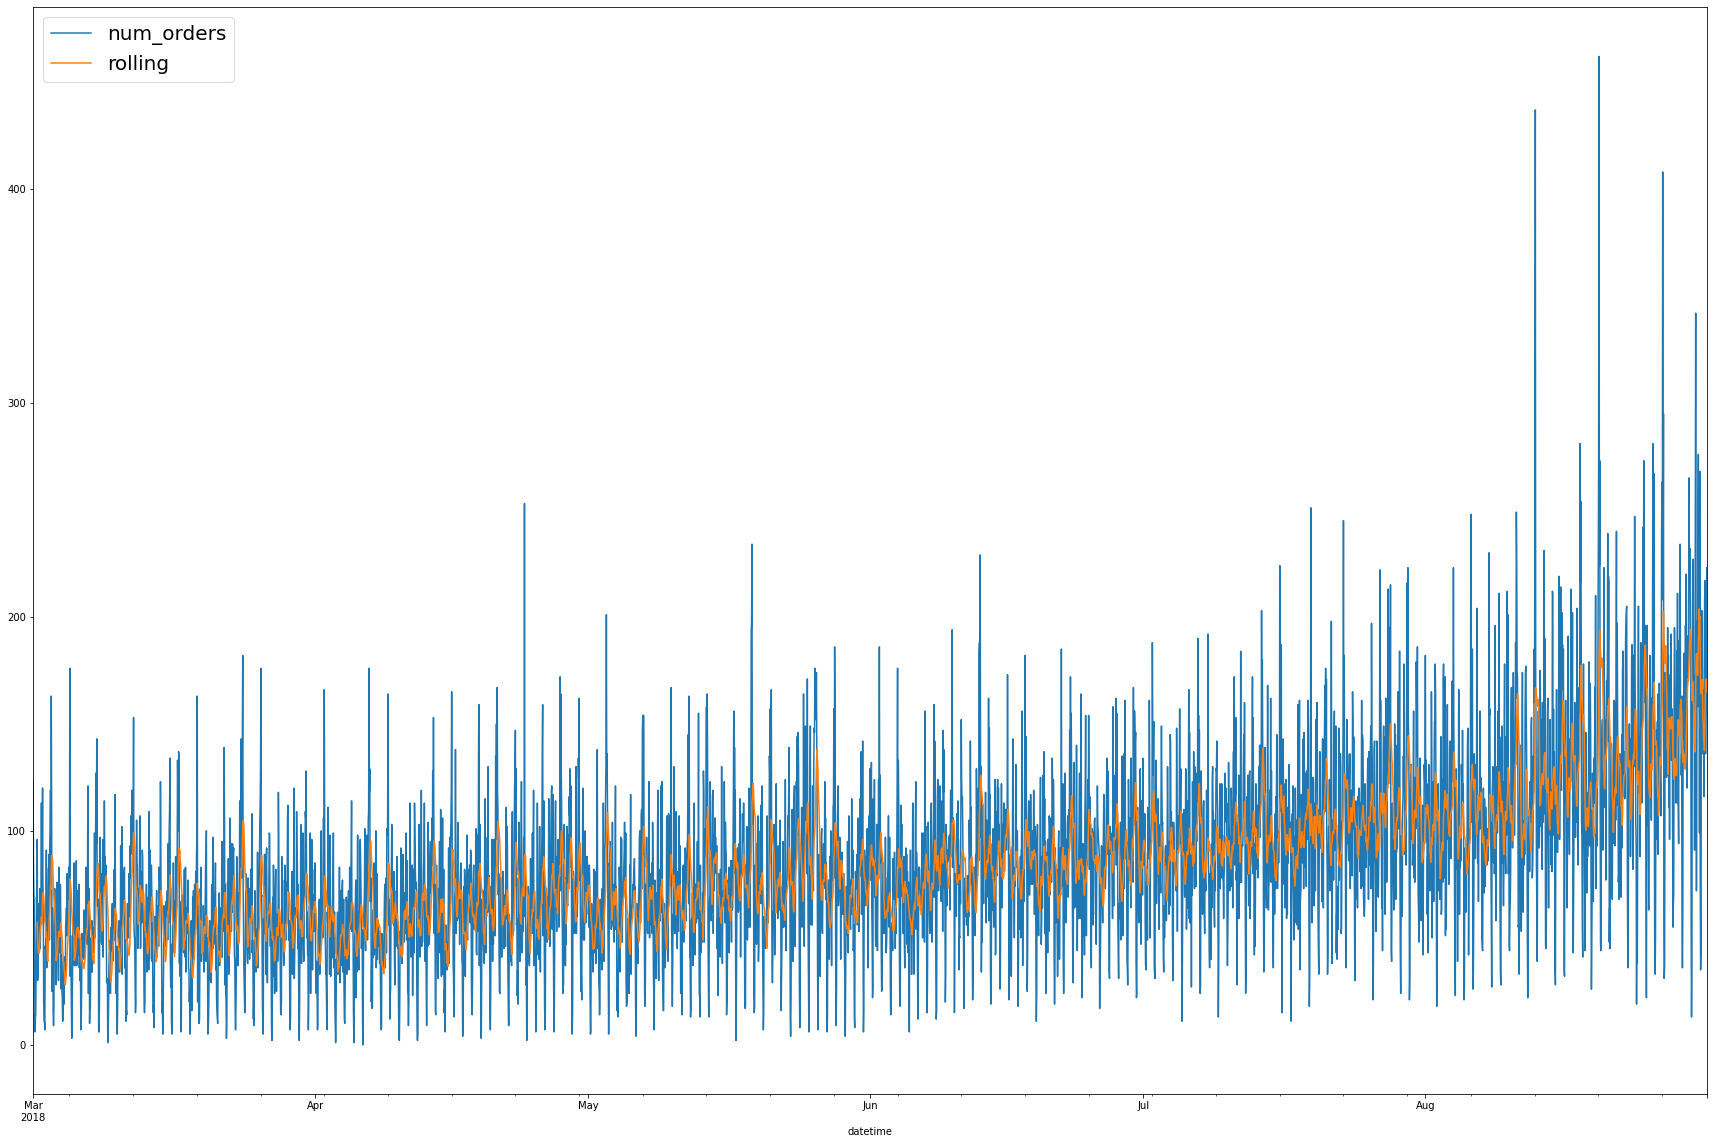

In [22]:
data = data.resample('1H').sum()
data['rolling'] = data['num_orders'].rolling(12).mean()
data.plot(figsize=(30,20))
plt.legend(prop={'size': 20});

In [23]:
decomposed = seasonal_decompose(data['num_orders'])

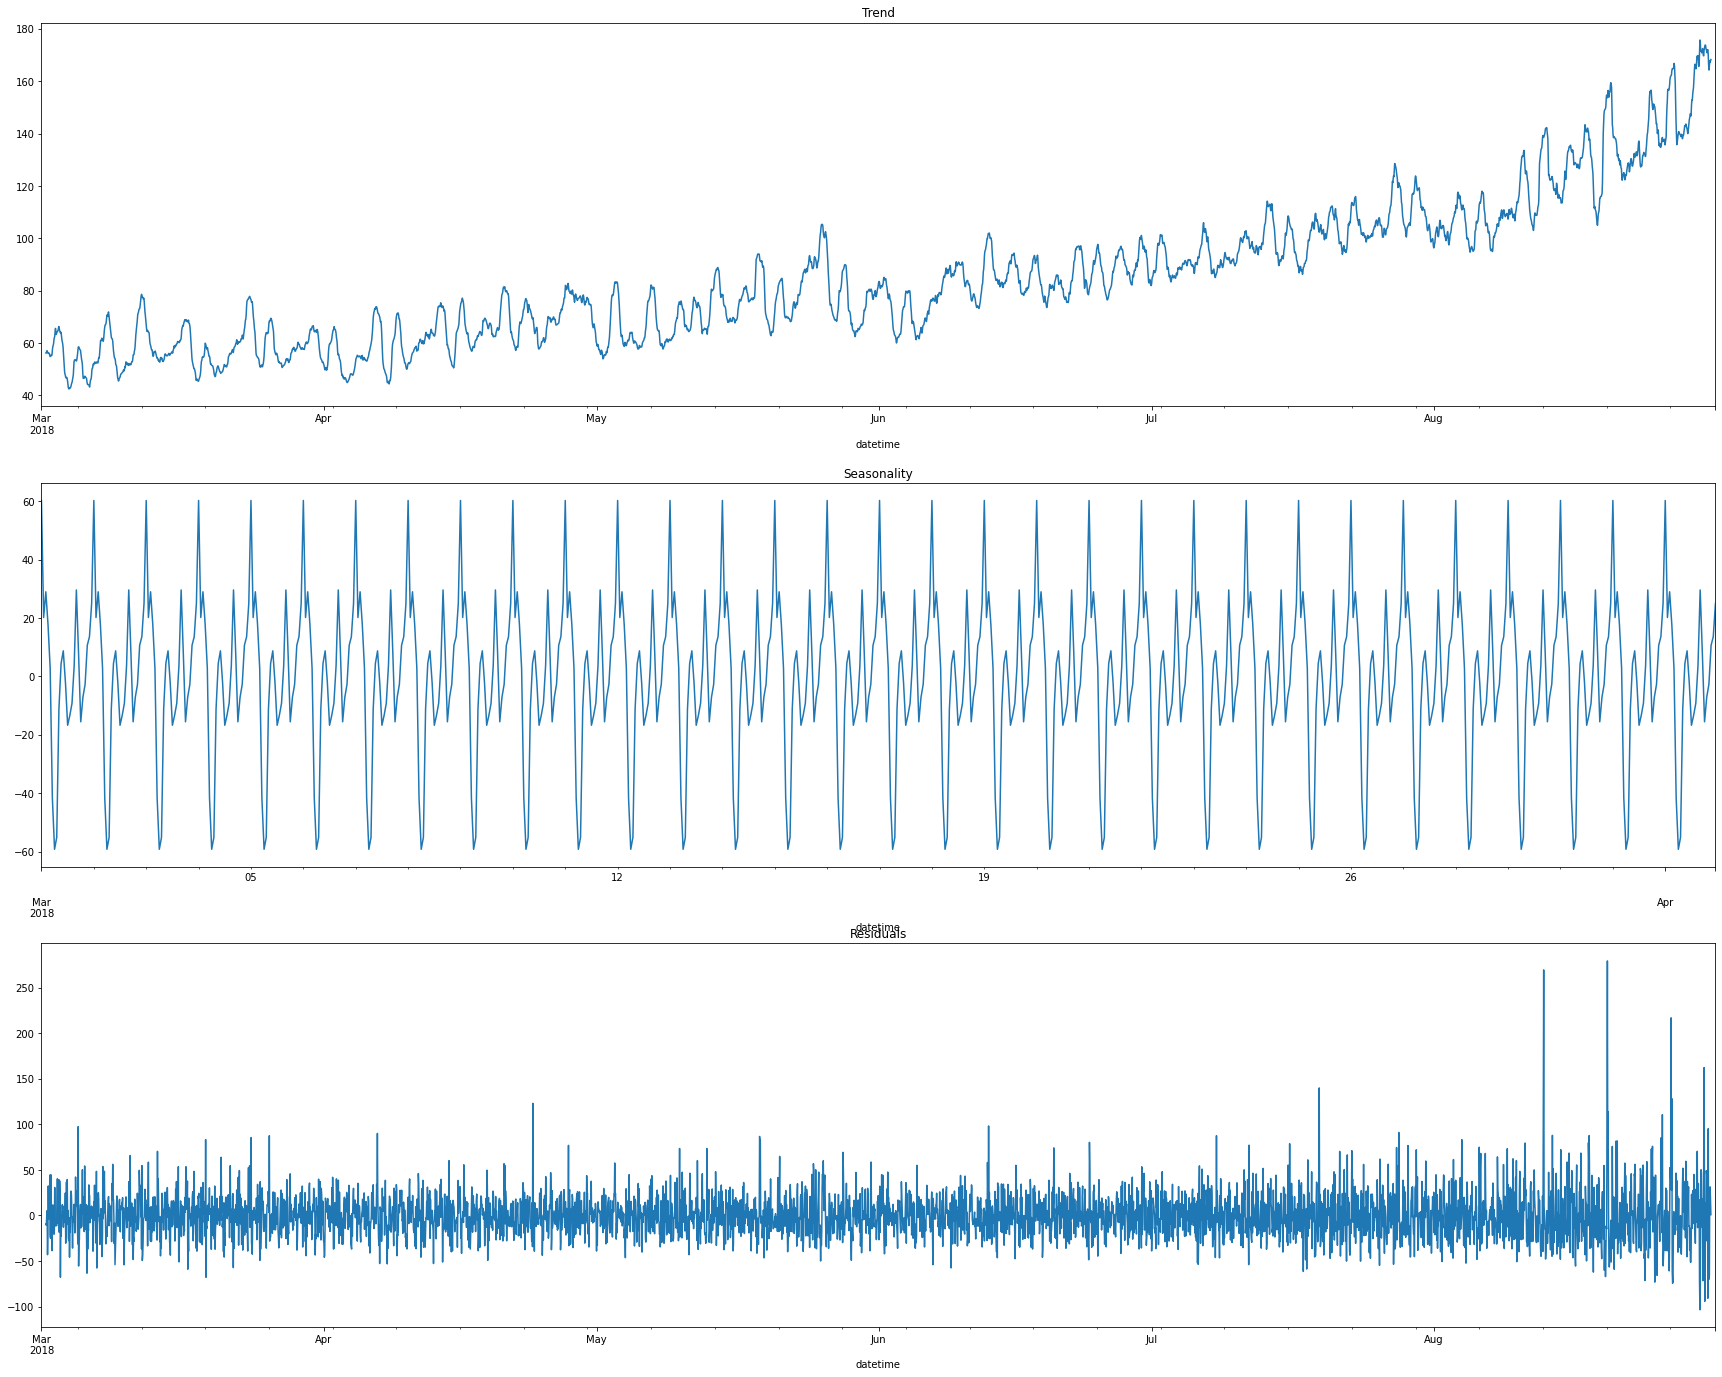

In [24]:
plt.figure(figsize=(30, 24))
plt.subplot(311)
decomposed.trend.plot()
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-04-01'].plot()
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot()
plt.title('Residuals');

Проведем тест Дики-Фуллера.

Нулевая гипотеза - процесс не стационарный.

Альтернативная гипотеза - прцесс стационарный.

In [25]:
# проведем тест Дики-Фуллера
# передадим ей столбец с данными о перевозках и поместим результат в adf_test

alpha = 0.05 # точность

test = adfuller(data['num_orders'])
# выведем p-value
print('p-value = ' + str(test[1]))
    
if test[1] < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не можем отвергнуть нулевую гипотезу')

p-value = 0.028940051402612906
Отвергаем нулевую гипотезу


Судя по графикам, такие компоненты как тренд и сезонность отсутствуют, рад является стационарным. Говоря более точно среднее значение и дисперсия не меняются во времени.

Создадим новые признаки:

    - календарные признаки
    - отстающие значения
    - скользящее окно (уже сделано)

In [26]:
def features(dt, max_lag):
    dt['year'] = dt.index.year
    dt['month'] = dt.index.month
    dt['day'] = dt.index.day
    dt['dayofweek'] = dt.index.dayofweek
    dt['hour'] = dt.index.hour
    for lag in range(1, max_lag + 1):
        dt['lag_{}'.format(lag)] = dt['num_orders'].shift(lag)
    dt.dropna(inplace=True)
    return dt
        
features(data,5)        

data.head()

,num_orders,rolling,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5
datetime,,,,,,,,,,,,
2018-03-01 11:00:00,96,57.083333,2018,3,1,3,11,64.0,69.0,34.0,15.0,12.0
2018-03-01 12:00:00,30,49.250000,2018,3,1,3,12,96.0,64.0,69.0,34.0,15.0
2018-03-01 13:00:00,32,44.833333,2018,3,1,3,13,30.0,96.0,64.0,69.0,34.0
2018-03-01 14:00:00,48,42.916667,2018,3,1,3,14,32.0,30.0,96.0,64.0,69.0
2018-03-01 15:00:00,66,42.916667,2018,3,1,3,15,48.0,32.0,30.0,96.0,64.0


## Обучение

Выделим обучающую и тестовую выборки. Закодируем категориальные признаки и шкалируем числовые признаки.

In [27]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

# выделяем категориальные и численные данные
cat_features = ['year', 'month', 'day', 'dayofweek', 'hour']
num_features = ['rolling', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5' ]

X_train_boost = train.drop('num_orders', axis=1)
y_train_boost = train['num_orders']
X_test_boost = test.drop('num_orders', axis=1)
y_test_boost = test['num_orders']

In [28]:
# порядковое кодирование
encoder = OrdinalEncoder()
encoder.fit(X_train_boost[cat_features])
X_train_boost[cat_features] = encoder.transform(X_train_boost[cat_features])
X_test_boost[cat_features] = encoder.transform(X_test_boost[cat_features])

# создадим объект этой структуры StandardScaler
scaler = StandardScaler()
# обучаем
scaler.fit(X_train_boost[num_features])
# преобразуем выборки
X_train_boost[num_features] = scaler.transform(X_train_boost[num_features])
X_test_boost[num_features] = scaler.transform(X_test_boost[num_features])

Построим несколько меделей подберем параметры.

### LGBMRegressor

In [12]:
# запускаем отсчёт времени
start = time.time()
# сохдаём модель и запускаем grid_search

model_LGBM = LGBMRegressor()
grid = {'num_leaves': [3, 7, 10],
        'learning_rate': [0.1, 0.03],
        'max_depth': [4, 6, 10]
}

tscv = TimeSeriesSplit(n_splits=3)

grid_LGBM = GridSearchCV(model_LGBM, grid, cv=tscv, n_jobs=-1, scoring='neg_root_mean_squared_error')
grid_LGBM.fit(X_train_boost, y_train_boost)
# фиксируем время
stop = time.time()

In [13]:
print('LGBMRegressor для подбора параметров требует', round((stop - start)/60, 2), 'минут')
print(f'Лучшие параметры модели {grid_LGBM.best_params_}')
print('MRSE', abs(grid_LGBM.best_score_))

LGBMRegressor для подбора параметров требует 0.25 минут
Лучшие параметры модели {'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 10}
MRSE 25.300150788004675


### CatBoostRegressor

In [14]:
# запускаем отсчёт времени
start = time.time()
# сохдаём модель и запускаем grid_search
model_cat = CatBoostRegressor(verbose=100)
grid = {'learning_rate': [0.03, 0.1],
        'max_depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7]}
tscv = TimeSeriesSplit(n_splits=3)
grid_cat = GridSearchCV(model_cat, grid, cv=tscv, n_jobs=-1, scoring='neg_root_mean_squared_error')
grid_cat.fit(X_train_boost, y_train_boost)
# фиксируем время
stop = time.time()

0:	learn: 28.9289953	total: 50.4ms	remaining: 50.4s
100:	learn: 17.7524512	total: 97.9ms	remaining: 871ms
200:	learn: 16.0232711	total: 146ms	remaining: 581ms
300:	learn: 14.7249877	total: 195ms	remaining: 452ms
400:	learn: 13.7218436	total: 241ms	remaining: 359ms
500:	learn: 12.9098478	total: 286ms	remaining: 285ms
600:	learn: 12.1865650	total: 332ms	remaining: 221ms
700:	learn: 11.4994924	total: 381ms	remaining: 163ms
800:	learn: 10.9018843	total: 434ms	remaining: 108ms
900:	learn: 10.3880773	total: 484ms	remaining: 53.2ms
999:	learn: 9.9125454	total: 534ms	remaining: 0us
0:	learn: 31.5345280	total: 995us	remaining: 995ms
100:	learn: 20.2651880	total: 68.1ms	remaining: 606ms
200:	learn: 18.4576020	total: 130ms	remaining: 519ms
300:	learn: 17.2229484	total: 191ms	remaining: 444ms
400:	learn: 16.1870088	total: 252ms	remaining: 376ms
500:	learn: 15.3575785	total: 314ms	remaining: 313ms
600:	learn: 14.7113829	total: 379ms	remaining: 251ms
700:	learn: 14.1337224	total: 444ms	remaining: 18

In [15]:
print('CatBoostRegressor для подбора параметров требует', round((stop - start)/60, 2), 'минут')
print(f'Лучшие параметры модели {grid_cat.best_params_}')
print('MRSE', abs(grid_cat.best_score_))

CatBoostRegressor для подбора параметров требует 5.87 минут
Лучшие параметры модели {'l2_leaf_reg': 1, 'learning_rate': 0.03, 'max_depth': 4}
MRSE 24.2107847790934


### Ridge

In [16]:
# формируем признаки и целевой признак
X_train_ridge = train.drop('num_orders', axis=1)
y_train_ridge = train['num_orders']
X_test_ridge = test.drop('num_orders', axis=1)
y_test_ridge = test['num_orders']

# кодируем категориальные признаки
X_train_ridge = pd.get_dummies(X_train_ridge)
X_test_ridge = pd.get_dummies(X_test_ridge)

# создадим объект этой структуры StandardScaler
scaler = StandardScaler()
# обучаем
scaler.fit(X_train_ridge[num_features])
# преобразуем выборки
X_train_ridge[num_features] = scaler.transform(X_train_ridge[num_features])
X_test_ridge[num_features] = scaler.transform(X_test_ridge[num_features])

In [17]:
# запускаем отсчёт времени
start = time.time()

# сохдаём модель и запускаем grid_search

model_ridge = Ridge()

grid = {'alpha' : [50,10, 1, 0.1, 0.01],
        'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
       }
tscv = TimeSeriesSplit(n_splits=3)
grid_r = GridSearchCV(model_ridge, param_grid=grid, cv=tscv, n_jobs=-1, scoring='neg_root_mean_squared_error')
grid_r.fit(X_train_ridge, y_train_ridge)
# фиксируем время
stop = time.time()

In [18]:
print('Ridge требует', round((stop - start)/60, 3), 'минут')
print (f'Лучшие параметры модели {grid_r.best_params_}')
print('MRSE', abs(grid_r.best_score_))

Ridge требует 0.111 минут
Лучшие параметры модели {'alpha': 0.1, 'solver': 'sag'}
MRSE 31.19999465310168


## Тестирование

Лучше всех себя показала модель CatBoostRegressor, проверим ее на тесте и на адекватность.

In [29]:
d = CatBoostRegressor(verbose=100, l2_leaf_reg=1, learning_rate=0.03, max_depth=4)
start = time.time()
d.fit(X_train_boost, y_train_boost)
stop = time.time()
print('На обучение требуется', round((stop - start)/60, 3), 'минут')
print('MRSE',mean_squared_error(y_test_boost,d.predict(X_test_boost), squared=False))

0:	learn: 38.1532079	total: 1.24ms	remaining: 1.24s
100:	learn: 23.7198229	total: 110ms	remaining: 980ms
200:	learn: 21.7088841	total: 213ms	remaining: 846ms
300:	learn: 20.5002837	total: 318ms	remaining: 739ms
400:	learn: 19.5581717	total: 424ms	remaining: 633ms
500:	learn: 18.8286847	total: 529ms	remaining: 527ms
600:	learn: 18.2529875	total: 635ms	remaining: 422ms
700:	learn: 17.7708855	total: 740ms	remaining: 316ms
800:	learn: 17.3609771	total: 845ms	remaining: 210ms
900:	learn: 17.0017547	total: 948ms	remaining: 104ms
999:	learn: 16.6829435	total: 1.05s	remaining: 0us
На обучение требуется 0.028 минут
MRSE 42.06295377824234


In [34]:
d.save_model('cat_model123456')

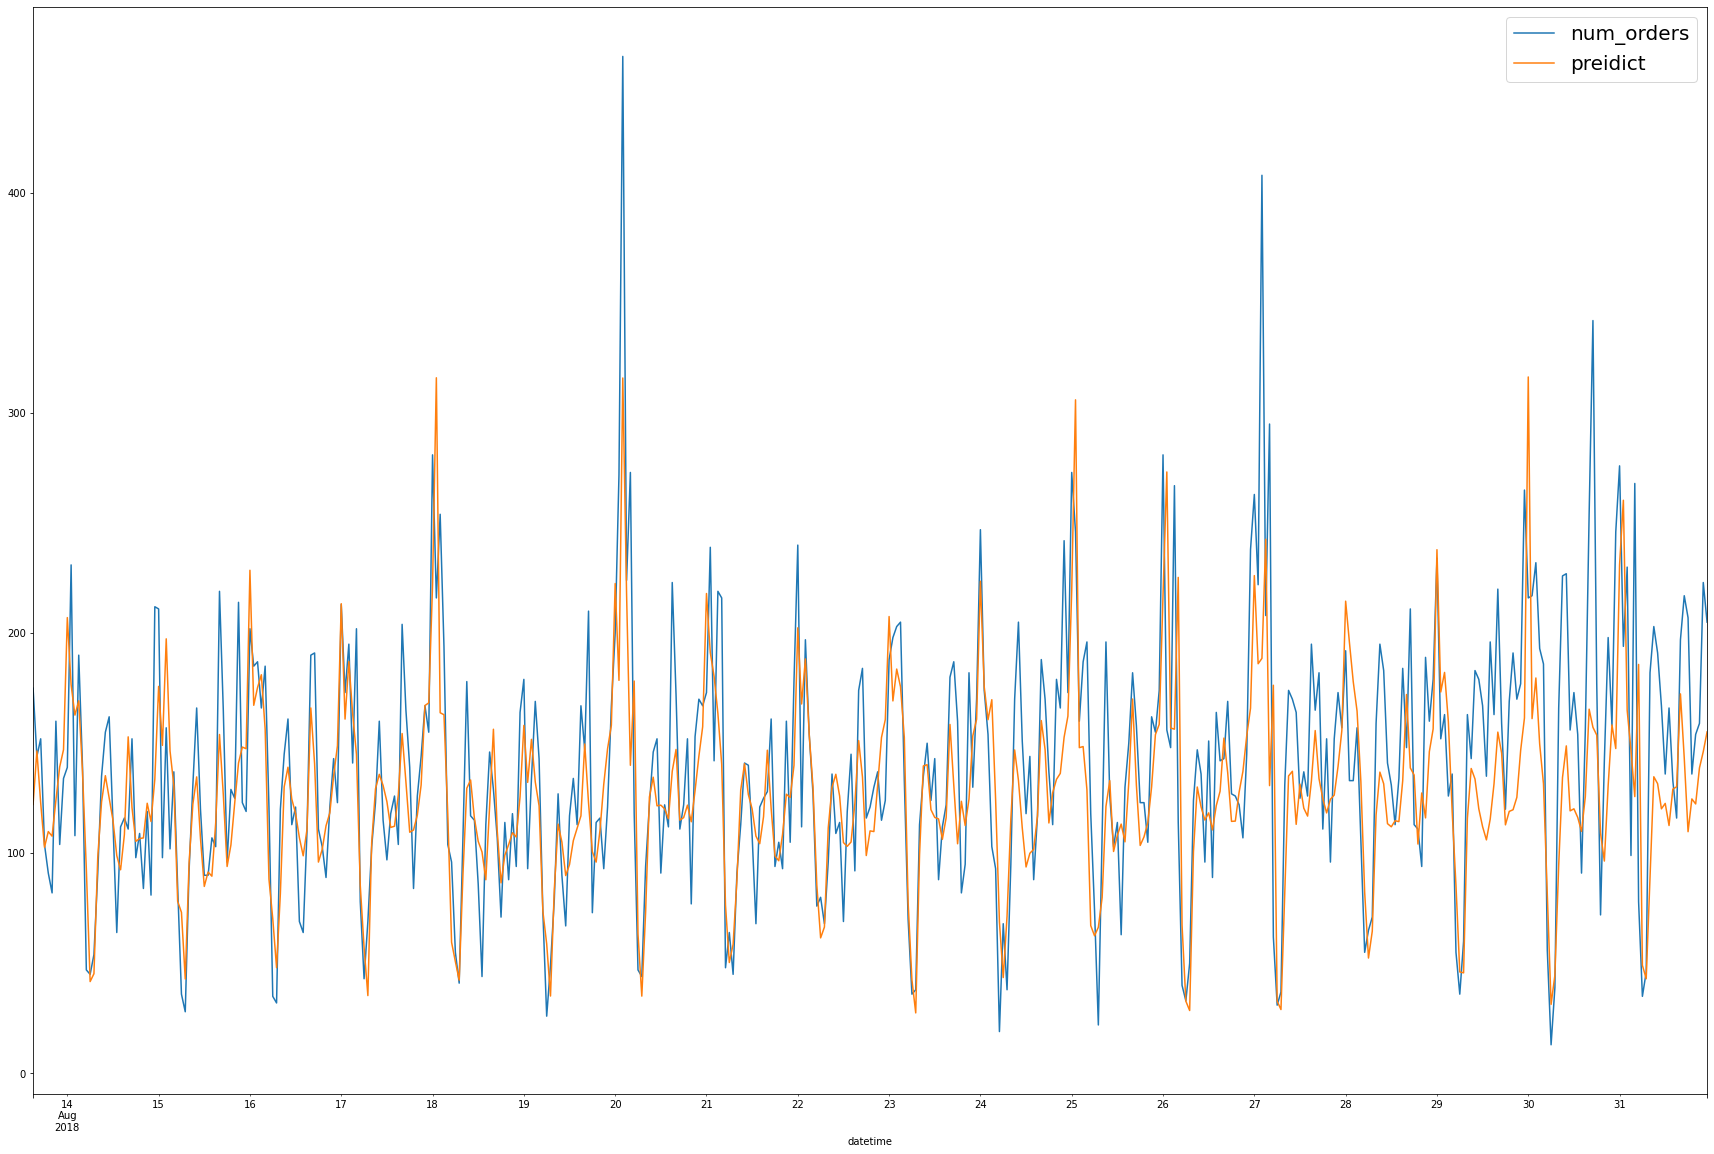

In [20]:
result = pd.DataFrame(y_test_boost)
result['preidict'] = Сat.predict(X_test_boost)
result.plot(figsize=(30,20))
plt.legend(prop={'size': 20});

In [21]:
# константная модель
constant = pd.Series(y_train_boost.mean(), index=y_test_boost.index)
mean_squared_error(constant,Сat.predict(X_test_boost), squared=False)

65.9226837936627

## Вывод

Данные загружены и исследованы монотонность, стационарность, на тренд и сезонность.

Обучены три модели:

**LGBMRegressor**

- Лучшие параметры модели {'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 10}
- MRSE 25.3

**CatBoostRegressor**

- Лучшие параметры модели {'l2_leaf_reg': 1, 'learning_rate': 0.03, 'max_depth': 4}
- MRSE 24.2

**Ridge**

- Лучшие параметры модели {'alpha': 1, 'solver': 'sag'}
- MRSE 31.1



Лучше себя показала модель CatBoostRegressor

- На обучение требуется 0.026 минут
- MRSE на тесте 42
- Модель прошла проверку на адекватность

Модель прогнозирует количество заказов на следующий час с точность 42 шт., этого достаточно для нашего задания.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48